# ROSSMANN

In this Kaggle competition, Rossmann, the second largest chain of German drug stores, challenged competitors to predict 6 weeks of daily sales for 1,115 stores located across Germany. According to the information provided, sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. In this post, we start from fetching the data from Kaggle. Next, we explore the contents of the data. Although this is a mostly structured clear data, we’ll have some challenges along the way. Using great Python data wrangling tools (Pandas, Numpy, etc.), we get over them quickly. The post ends after prediction of the sales for the test data. Thus, we have a complete solution to a real-world marketing problem (with a data in good condition).

## Analysis

The important part is to ask the right questions. So, we ask and answer the questions while digging deeper in exploratory phase. Let’s start with a high-level overview of the data. First, we need to import necessary libraries. We use Pandas for fetching and manipulating data, and also for plotting; Matplotlib and Seaborn for plotting; Numpy and Scipy for manipulating data.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


### Train Dataset

In [3]:
train = pd.read_csv("../rossmann-store-sales/train.csv", sep=',', parse_dates=['Date'],
                    dtype={'StateHoliday': str, 'SchoolHoliday':str})

test = pd.read_csv("../rossmann-store-sales/test.csv", sep=",", index_col = 'Id', parse_dates=['Date'],
                  dtype={'StateHoliday': str, 'SchoolHoliday':str})

store = pd.read_csv("../rossmann-store-sales/store.csv", sep=",", dtype={'StoreType': str,
                                                      'Assortment': str,
                                                      'PromoInterval': str})


Let’s see the top rows of train dataframe using head() function. There are nine columns. The target column is Salescolumn. After first look, we should be wondering, “How many distinct Stores are there?”, “Are all of the Days in a Week included in this dataset?”, “What is the Date interval?”, “I want to know the levels of Open, Promo, StateHoliday and School Holidays!”. We will address these questions, soon.



In [4]:
display(train.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
display(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [6]:
sum(train['Open'] == 0)

172817

In [7]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month

In [8]:
train = train[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
               'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales']]
list(train.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Sales']

In [9]:
train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday            object
Sales                     int64
dtype: object

How many types of State Holiday in Germany? Or in Rossmann’s world?

In [10]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [11]:
train.loc[train['StateHoliday'] == '0', 'StateHoliday'] = 0
train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = 1
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = 2
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = 3
train['StateHoliday'] = train['StateHoliday'].astype(int, copy=False)

In [12]:
print('levels :', train['StateHoliday'].unique(), '; data type :', train['StateHoliday'].dtype)

levels : [0 1 2 3] ; data type : int64


Create a function to automatize the previous work.

In [13]:
def factor_to_integer(df, colname, start_value=0):
    while df[colname].dtype == object:
        myval = start_value # factor starts at "start_value".
        for sval in df[colname].unique():
            df.loc[df[colname] == sval, colname] = myval
            myval += 1
        df[colname] = df[colname].astype(int, copy=False)
    print('levels :', df[colname].unique(), '; data type :', df[colname].dtype)


How many types of School Holiday in Germany?

In [14]:
train['SchoolHoliday'].unique()

array(['1', '0'], dtype=object)

In [15]:
factor_to_integer(train, 'SchoolHoliday')

levels : [0 1] ; data type : int64


Check the data types for each column.

In [16]:
train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday              int64
SchoolHoliday             int64
Sales                     int64
dtype: object

An view of the data.

In [17]:
train.describe()

,Store,DayOfWeek,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2.013832e+03,5.846762e+00,6.331459e+02,8.301067e-01,3.815145e-01,4.516279e-02,8.213533e-01,5.773819e+03
std,3.219087e+02,1.997391e+00,7.773960e-01,3.326097e+00,4.644117e+02,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,3.849926e+03
min,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2.013000e+03,3.000000e+00,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.727000e+03
50%,5.580000e+02,4.000000e+00,2.014000e+03,6.000000e+00,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.744000e+03
75%,8.380000e+02,6.000000e+00,2.014000e+03,8.000000e+00,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,7.856000e+03
max,1.115000e+03,7.000000e+00,2.015000e+03,1.200000e+01,7.388000e+03,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.155100e+04


A Rossmann shop is either open or close, as expected, but the following code is also for checking the NaN values:

In [18]:
train['Open'].unique()

array([1, 0])

Select columns for the train data:



In [19]:
train = train[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
               'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales']]
list(train.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Sales']

Check for number of NaNs for selected columns.

In [20]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : train[colname].isnull().sum() for colname in train.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Customers', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Sales', 0)]

Compute pairwise correlation of columns using pandas.corr() function.

In [21]:
corMat = pd.DataFrame(train.loc[:, ['DayOfWeek', 'Sales', 'Month', 'Year', 'Customers', 'Promo',
                                    'StateHoliday', 'SchoolHoliday']].corr())
display(corMat)

,DayOfWeek,Sales,Month,Year,Customers,Promo,StateHoliday,SchoolHoliday
DayOfWeek,1.000000,-0.462125,-0.005362,0.001937,-0.386445,-0.392925,-0.044265,0.205388
Sales,-0.462125,1.000000,0.048768,0.023519,0.894711,0.452345,-0.229029,-0.085124
Month,-0.005362,0.048768,1.000000,-0.269382,0.038179,-0.011747,0.038058,-0.103282
Year,0.001937,0.023519,-0.269382,1.000000,-0.001212,0.024300,-0.005067,0.036535
Customers,-0.386445,0.894711,0.038179,-0.001212,1.000000,0.316169,-0.204295,-0.071568
Promo,-0.392925,0.452345,-0.011747,0.024300,0.316169,1.000000,-0.024157,-0.067483
StateHoliday,-0.044265,-0.229029,0.038058,-0.005067,-0.204295,-0.024157,1.000000,-0.196424
SchoolHoliday,0.205388,-0.085124,-0.103282,0.036535,-0.071568,-0.067483,-0.196424,1.000000


Visualize correlation of the DataFrame using matplotlib.pcolor() function. Gray level correspond to the level of the measurement. Darker cells indicate high correlation.

Seaborn specializes in static charts and makes making a heatmap from a Pandas DataFrame simple and a little bit nicer than matplotlib. Colors correspond to the level of the measurement.


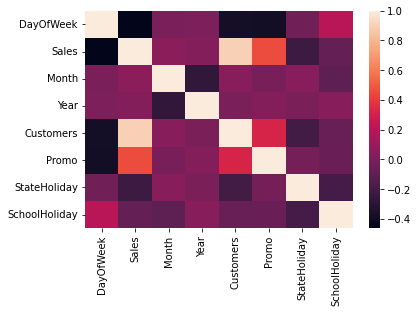

In [22]:
sns.heatmap(data=corMat)
plt.show()

### Test Dataset

In [23]:
test.shape

(41088, 7)

In [24]:
test['Year'] = pd.DatetimeIndex(test['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month

In [25]:
test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Id,,,,,,,,,
1,1,4,2015-09-17,1.0,1,0,0,2015,9
2,3,4,2015-09-17,1.0,1,0,0,2015,9
3,7,4,2015-09-17,1.0,1,0,0,2015,9
4,8,4,2015-09-17,1.0,1,0,0,2015,9
5,9,4,2015-09-17,1.0,1,0,0,2015,9


In [26]:
test.tail()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Id,,,,,,,,,
41084,1111,6,2015-08-01,1.0,0,0,0,2015,8
41085,1112,6,2015-08-01,1.0,0,0,0,2015,8
41086,1113,6,2015-08-01,1.0,0,0,0,2015,8
41087,1114,6,2015-08-01,1.0,0,0,0,2015,8
41088,1115,6,2015-08-01,1.0,0,0,1,2015,8


In [27]:
sum(test['Open'] == 0)

5984

Change the column names of the test dataset to get construct same feature names with the train dataset.

In [28]:
test = test[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Open',
             'Promo', 'StateHoliday', 'SchoolHoliday']]
list(test.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday']

For each column, see how many missing values exist.

In [29]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Open', 11),
 ('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0)]

There are 11 missing values in Open column. Let’s have a detailed look at those:

In [30]:
display(test.loc[np.isnan(test['Open'])])

,Store,DayOfWeek,Date,Year,Month,Open,Promo,StateHoliday,SchoolHoliday
Id,,,,,,,,,
480,622,4,2015-09-17,2015,9,NaN,1,0,0
1336,622,3,2015-09-16,2015,9,NaN,1,0,0
2192,622,2,2015-09-15,2015,9,NaN,1,0,0
3048,622,1,2015-09-14,2015,9,NaN,1,0,0
4760,622,6,2015-09-12,2015,9,NaN,0,0,0
5616,622,5,2015-09-11,2015,9,NaN,0,0,0
6472,622,4,2015-09-10,2015,9,NaN,0,0,0
7328,622,3,2015-09-09,2015,9,NaN,0,0,0
8184,622,2,2015-09-08,2015,9,NaN,0,0,0


Do we have any information about store 622? Check train dataset:

In [31]:
train.loc[train['Store'] == 622].head()

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
621,622,5,2015-07-31,2015,7,540,1,1,0,0,6306
1736,622,4,2015-07-30,2015,7,406,1,1,0,0,5412
2851,622,3,2015-07-29,2015,7,468,1,1,0,0,5326
3966,622,2,2015-07-28,2015,7,417,1,1,0,0,4966
5081,622,1,2015-07-27,2015,7,517,1,1,0,0,5413


Avoid missing any information. So deleting the rows of Store 622 which have missing Open value, should be our last option. Either label it 0 or 1. As seen above, we have data for Store 622 in train dataset. Therefore, let’s label missing values of Open column in test dataset as 1.

In [32]:
test.loc[np.isnan(test['Open']), 'Open'] = 1

Checking if there are any missing values left.

In [33]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0)]

Check for the data types for test dataset.

In [34]:
test.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday            object
dtype: object

We have one state holiday in this dataset:

In [35]:
test['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

We have one school holiday in this dataset:

In [36]:
test['SchoolHoliday'].unique()

array(['0', '1'], dtype=object)

Change the categorical values (string type) of StateHoliday and SchoolHoliday columns to integers.

In [37]:
factor_to_integer(test, 'StateHoliday')
factor_to_integer(test, 'SchoolHoliday')
test.dtypes

levels : [0 1] ; data type : int64
levels : [0 1] ; data type : int64


Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Open                    float64
Promo                     int64
StateHoliday              int64
SchoolHoliday             int64
dtype: object

Because only StateHoliday 0 and 1 exist in test dataset, we should consider deleting the rows in train dataset that the StateHoliday value is different than 0 or 1.

In [38]:
train.loc[train['StateHoliday'] > 1].shape

(10790, 11)

In [39]:
train = train.loc[train['StateHoliday'] < 2]

### Store Dataset

In [40]:
store.shape

(1115, 10)

In [41]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [42]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Are there any missing values in this dataset?

In [43]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Promo2SinceWeek', 544),
 ('Promo2SinceYear', 544),
 ('PromoInterval', 544),
 ('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0)]

Promo2SinceWeek, Promo2Interval, Promo2SinceYear, CompetitionOpenSinceMonth, CompetitionOpenSinceYear and CompetitionDistance columns have different size of missing values. We’ll first the contents, unique values in those columns then consider imputation using either scikit-learn or pandas built-in commands.

In [44]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

If there is no promotion, then the corresponding columns should have zero values.

In [45]:
store.loc[store['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

In [46]:
store.loc[store['Promo2'] != 0, 'Promo2SinceWeek'] = store['Promo2SinceWeek'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceWeek']

In [47]:
store.loc[store['Promo2'] != 0, 'Promo2SinceYear'] = store['Promo2SinceYear'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceYear']

In [48]:
factor_to_integer(store, 'PromoInterval', start_value=0)

levels : [0 1 2 3] ; data type : int64


Check the data types.

In [49]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object

Change the categorical values (string type) of StoreType and Assortment columns to integers. Check the results.

In [50]:
factor_to_integer(store, 'StoreType')
factor_to_integer(store, 'Assortment')
store.dtypes

levels : [0 1 2 3] ; data type : int64
levels : [0 1 2] ; data type : int64


Store                          int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object

An overview of the data after the latest settings.

In [51]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,1,0,570.0,11.0,2007.0,1,37.0,5.0,1
2,3,1,0,14130.0,12.0,2006.0,1,36.0,4.0,1
3,4,0,1,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,1,0,29910.0,4.0,2015.0,0,0.0,0.0,0


Are there still missing values?

In [52]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

Filling the missing values with sklearn’s built-in command. Filling with the column.mean().

In [53]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer().fit(store)
store_imputed = imputer.transform(store)

Check the results.

In [54]:
store2 = pd.DataFrame(store_imputed, columns=store.columns.values)

In [55]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store2[colname].isnull().sum() for colname in store2.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('CompetitionDistance', 0),
 ('CompetitionOpenSinceMonth', 0),
 ('CompetitionOpenSinceYear', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [56]:
store2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1.0,0.0,0.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0
1,2.0,1.0,0.0,570.0,11.0,2007.0,1.0,37.0,5.0,1.0
2,3.0,1.0,0.0,14130.0,12.0,2006.0,1.0,36.0,4.0,1.0
3,4.0,0.0,1.0,620.0,9.0,2009.0,0.0,0.0,0.0,0.0
4,5.0,1.0,0.0,29910.0,4.0,2015.0,0.0,0.0,0.0,0.0


In [57]:
store2['CompetitionOpenSinceMonth'] = store2['CompetitionOpenSinceMonth'].max() - store2['CompetitionOpenSinceMonth']

In [58]:
store2['CompetitionOpenSinceYear'] = store2['CompetitionOpenSinceYear'].max() - store2['CompetitionOpenSinceYear']

In [59]:
store2.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111.0,1.0,0.0,1900.0,6.000000,1.000000,1.0,19.0,2.0,1.0
1111,1112.0,0.0,1.0,1880.0,8.000000,9.000000,0.0,0.0,0.0,0.0
1112,1113.0,1.0,1.0,9260.0,4.775296,6.331143,0.0,0.0,0.0,0.0
1113,1114.0,1.0,1.0,870.0,4.775296,6.331143,0.0,0.0,0.0,0.0
1114,1115.0,2.0,1.0,5350.0,4.775296,6.331143,1.0,28.0,3.0,3.0


Are the Store column similar in both train and store datasets?

In [60]:
len(store2['Store']) - sum(store2['Store'].isin(train['Store']))

0

In [61]:
# Checking if there are additional (unnecessary) stores in "train" data.
# No difference at all!

StoreStore = pd.Series(store2['Store']); StoreTrain = pd.Series(train['Store'])

sum(StoreTrain.isin(StoreStore) == False)

0

Merge train and store datasets before modeling the data.

In [62]:
train_store = pd.merge(train, store2, how = 'left', on='Store')

Check the results.

In [63]:
train_store.head()

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,2015,7,555,1,1,0,0,5263,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,2,5,2015-07-31,2015,7,625,1,1,0,0,6064,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0
2,3,5,2015-07-31,2015,7,821,1,1,0,0,8314,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,4,5,2015-07-31,2015,7,1498,1,1,0,0,13995,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0
4,5,5,2015-07-31,2015,7,559,1,1,0,0,4822,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0


In [64]:
train_store.tail()

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1006414,1111,2,2013-01-01,2013,1,0,0,0,1,0,0,1.0,0.0,1900.0,6.000000,1.000000,1.0,19.0,2.0,1.0
1006415,1112,2,2013-01-01,2013,1,0,0,0,1,0,0,0.0,1.0,1880.0,8.000000,9.000000,0.0,0.0,0.0,0.0
1006416,1113,2,2013-01-01,2013,1,0,0,0,1,0,0,1.0,1.0,9260.0,4.775296,6.331143,0.0,0.0,0.0,0.0
1006417,1114,2,2013-01-01,2013,1,0,0,0,1,0,0,1.0,1.0,870.0,4.775296,6.331143,0.0,0.0,0.0,0.0
1006418,1115,2,2013-01-01,2013,1,0,0,0,1,0,0,2.0,1.0,5350.0,4.775296,6.331143,1.0,28.0,3.0,3.0


Merge test and store datasets and check the result.

In [65]:
test_store = test.reset_index().merge(store2, how = 'left', on='Store').set_index('Id')

In [66]:
test_store.head()

,Store,DayOfWeek,Date,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Id,,,,,,,,,,,,,,,,,,
1,1,4,2015-09-17,2015,9,1.0,1,0,0,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
2,3,4,2015-09-17,2015,9,1.0,1,0,0,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,7,4,2015-09-17,2015,9,1.0,1,0,0,1.0,1.0,24000.0,8.0,2.0,0.0,0.0,0.0,0.0
4,8,4,2015-09-17,2015,9,1.0,1,0,0,1.0,0.0,7520.0,2.0,1.0,0.0,0.0,0.0,0.0
5,9,4,2015-09-17,2015,9,1.0,1,0,0,1.0,1.0,2030.0,4.0,15.0,0.0,0.0,0.0,0.0


In [67]:
test_store.shape

(41088, 18)

In [68]:
test_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Year                         0
Month                        0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## Visual Exploration

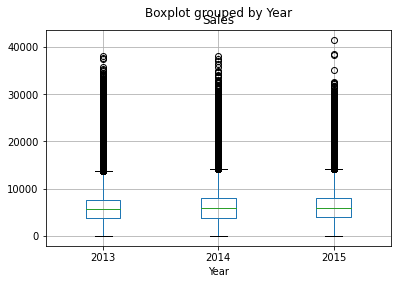

In [69]:
train_store.boxplot(column='Sales', by='Year')
plt.show()

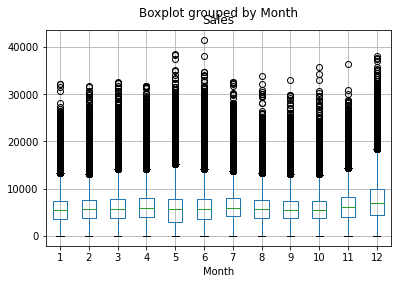

In [70]:
train_store.boxplot(column='Sales', by='Month')
plt.show()

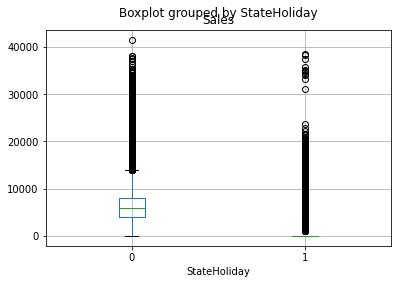

In [71]:
train_store.boxplot(column='Sales', by='StateHoliday')
plt.show()

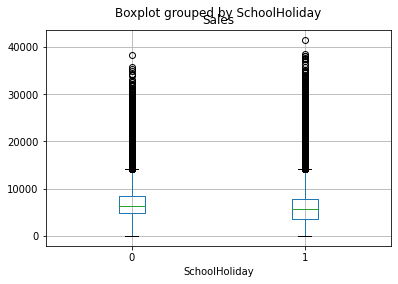

In [72]:
train_store.boxplot(column='Sales', by='SchoolHoliday')
plt.show()

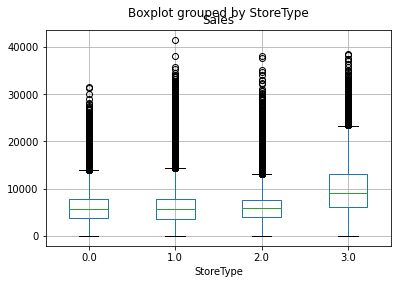

In [73]:
train_store.boxplot(column='Sales', by='StoreType')
plt.show()

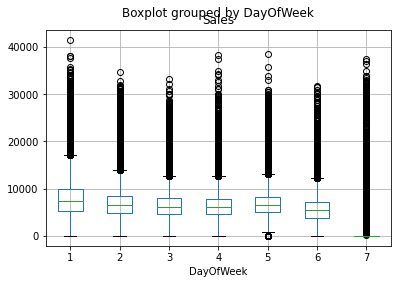

In [74]:
train_store.boxplot(column='Sales', by='DayOfWeek')
plt.show()

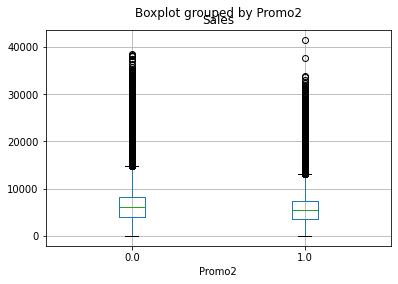

In [75]:
train_store.boxplot(column='Sales', by='Promo2')
plt.show()

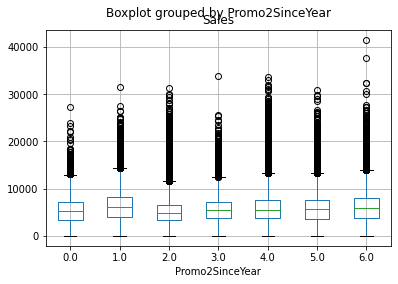

In [76]:
train_store.loc[train_store['Promo2'] != 0].boxplot(column='Sales', by='Promo2SinceYear')
plt.show()

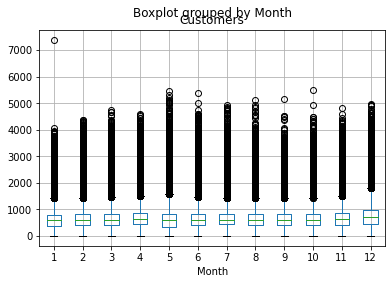

In [77]:
train_store.boxplot(column='Customers', by='Month')
plt.show()

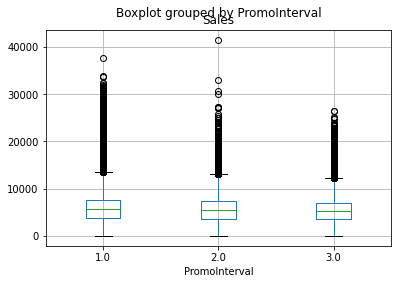

In [78]:
train_store.loc[train_store['Promo2'] != 0].boxplot(column='Sales', by='PromoInterval')
plt.show()

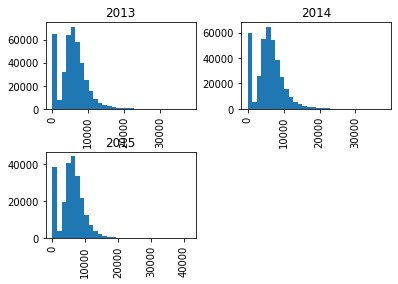

In [79]:
train_store.hist(column='Sales', by='Year', bins=30)
plt.show()

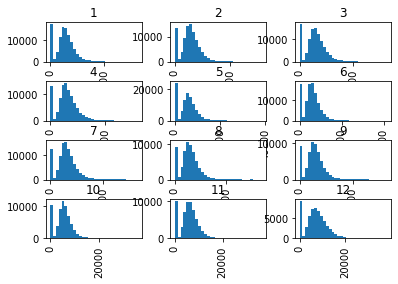

In [80]:
train_store.hist(column='Sales', by='Month', bins=30)
plt.show()

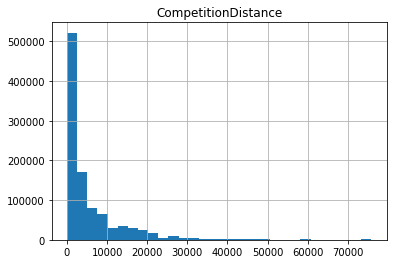

In [81]:
train_store.hist(column='CompetitionDistance', bins=30)
plt.show()

## MODELING

In [82]:
train_store.columns.values

array(['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], dtype=object)

In [83]:
train_model = train_store.drop(['Customers', 'Date'], axis=1)
train_model['Year'] = train_model['Year'].max() - train_model['Year']
train_model.head()

,Store,DayOfWeek,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,0,7,1,1,0,0,5263,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,2,5,0,7,1,1,0,0,6064,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0
2,3,5,0,7,1,1,0,0,8314,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,4,5,0,7,1,1,0,0,13995,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0
4,5,5,0,7,1,1,0,0,4822,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0


In [84]:
test_model = test_store.drop(['Date'], axis=1)
test_model['Year'] = test_model['Year'].max() - test_model['Year']

In [85]:
test_model.head()

,Store,DayOfWeek,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Id,,,,,,,,,,,,,,,,,
1,1,4,0,9,1.0,1,0,0,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
2,3,4,0,9,1.0,1,0,0,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,7,4,0,9,1.0,1,0,0,1.0,1.0,24000.0,8.0,2.0,0.0,0.0,0.0,0.0
4,8,4,0,9,1.0,1,0,0,1.0,0.0,7520.0,2.0,1.0,0.0,0.0,0.0,0.0
5,9,4,0,9,1.0,1,0,0,1.0,1.0,2030.0,4.0,15.0,0.0,0.0,0.0,0.0


In [86]:
test_model_open = test_model.loc[test_model['Open'] == 1]
#test_model_open = test_model_open.drop('Open', axis=1)

test_model_close = test_model.loc[test_model['Open'] == 0]

test_model_open.head()

,Store,DayOfWeek,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Id,,,,,,,,,,,,,,,,,
1,1,4,0,9,1.0,1,0,0,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
2,3,4,0,9,1.0,1,0,0,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,7,4,0,9,1.0,1,0,0,1.0,1.0,24000.0,8.0,2.0,0.0,0.0,0.0,0.0
4,8,4,0,9,1.0,1,0,0,1.0,0.0,7520.0,2.0,1.0,0.0,0.0,0.0,0.0
5,9,4,0,9,1.0,1,0,0,1.0,1.0,2030.0,4.0,15.0,0.0,0.0,0.0,0.0


In [87]:
test_model_open.isnull().sum()

Store                        0
DayOfWeek                    0
Year                         0
Month                        0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [88]:
train_model.shape

(1006419, 18)

In [89]:
test_model.shape

(41088, 17)

In [90]:
SalesDF = train_model['Sales']
train_model = train_model.drop(['Sales'], axis=1)
train_model['Sales'] = SalesDF

In [91]:
train_model.head()

,Store,DayOfWeek,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales
0,1,5,0,7,1,1,0,0,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0,5263
1,2,5,0,7,1,1,0,0,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0,6064
2,3,5,0,7,1,1,0,0,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0,8314
3,4,5,0,7,1,1,0,0,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0,13995
4,5,5,0,7,1,1,0,0,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0,4822


In [92]:
summary = train_model.describe()
train_normalized = train_model.copy()
ncols = len(train_normalized.columns)

for i in range(ncols):
    mean = summary.iloc[1, i]
    sd = summary.iloc[2, i]
    train_normalized.iloc[:,i:(i + 1)] = \
        (train_normalized.iloc[:,i:(i + 1)] - mean) / sd

In [93]:
sales_normalized = train_normalized['Sales']
train_normalized = train_normalized.drop(['Sales'], axis=1)
train_normalized['Sales'] = sales_normalized

In [94]:
train_normalized.head()

,Store,DayOfWeek,Year,Month,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales
0,-1.731639,0.497609,-1.501199,0.351249,0.438396,1.27117,-0.143333,-2.207088,-1.770361,-0.930468,-0.539891,-0.669720,0.138083,-1.001134,-0.802376,-0.810676,-0.824297,-0.149270
1,-1.728533,0.497609,-1.501199,0.351249,0.438396,1.27117,-0.143333,-2.207088,-0.300229,-0.930468,-0.630738,-1.423676,0.340127,0.998866,1.416358,1.683018,0.194891,0.060270
2,-1.725426,0.497609,-1.501199,0.351249,0.438396,1.27117,-0.143333,-2.207088,-0.300229,-0.930468,1.129094,-1.800655,0.542171,0.998866,1.356392,1.184279,0.194891,0.648863
3,-1.722320,0.497609,-1.501199,0.351249,0.438396,1.27117,-0.143333,-2.207088,-1.770361,1.008815,-0.624249,-0.669720,-0.063961,-1.001134,-0.802376,-0.810676,-0.824297,2.134997
4,-1.719213,0.497609,-1.501199,0.351249,0.438396,1.27117,-0.143333,-2.207088,-0.300229,-0.930468,3.177039,1.215170,-1.276224,-1.001134,-0.802376,-0.810676,-0.824297,-0.264634


In [95]:
from sklearn.model_selection import train_test_split
X = train_model.drop('Sales', axis=1)
y = train_model['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train),
                                  columns=X.columns.values)

X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                                  columns=X.columns.values)

test_model_open_scaled = pd.DataFrame(scaler.transform(test_model_open),
                                  columns=test_model_open.columns.values)

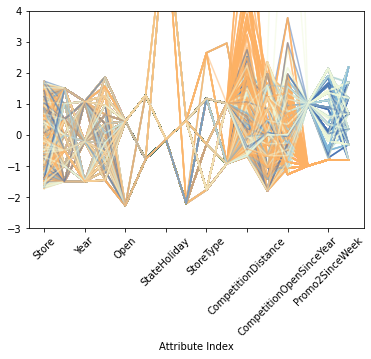

In [97]:
import numpy as np

# get summary to use for scaling
summary = X_train_scaled.describe()
meanSales = summary.iloc[1, 7]
sdSales = summary.iloc[2, 7]
nrows = np.random.randint(0, len(X_train_scaled.index), 2000)

for i in nrows:
    # plot rows of data as if they were series data
    dataRow = X_train_scaled.iloc[i, :-1]
    normTarget = X_train_scaled.iloc[i, -1]
    labelColor = 1.0 / (1.0 + np.exp(-normTarget))
    dataRow.plot(color = plt.cm.RdYlBu(labelColor), alpha=0.5)

plt.ylim([-3,4])
plt.xticks(rotation=45)
plt.xlabel("Attribute Index")
plt.show()

In [98]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state=43,verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestRegressor(n_jobs=-1, random_state=43, verbose=1)

In [99]:
rf.score(X_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.2s finished


0.9309957797769348

In [100]:
test_model = test_model.drop(['Sales'], axis=1, errors='ignore')
test_model['Sales'] = rf.predict(test_model)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


In [101]:
submission = test_model['Sales']
submission = submission.reset_index()
submission.head()

,Id,Sales
0,1,4419.978524
1,2,8199.535833
2,3,11343.874833
3,4,8463.683000
4,5,7861.608214


In [102]:
submission.tail()

,Id,Sales
41083,41084,2654.266997
41084,41085,6994.418500
41085,41086,5640.717595
41086,41087,21428.698706
41087,41088,7077.644298


In [103]:
submission.to_csv("../result/submission_open.csv", sep=',', index=False)

In [104]:
train_model.to_csv("../explore/train_model.csv", sep=',', index=False)

In [105]:
test_model.reset_index().to_csv("../explore/test_model.csv", sep=',', index=False)

## Summary

This long post will be best for a novice data analyst to explore all steps of a real-world analysis. Actually not a real data analysis though. Anyways, exploratory data analysis revealed several novel features. Training data was provided for 1,115 Rossmann stores from January 1st 2013 through July 31st 2015 .The task was to forecast 6 weeks (August 1st 2015 through September 17th 2015) of sales for 856 of the Rossmann stores identified within the testing data. Although we scored (\(R^2=0.92\)) for the train_test data (which normally is great), the private results in the competition show that we have a long way to the top 
